# Step 1: Imports #

We begin by importing several Python packages.

In [2]:
!pip install -q efficientnet

In [3]:
import math, re, os
import numpy as np
import tensorflow as tf

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.6.4


In [4]:
from tensorflow import keras
from kaggle_datasets import KaggleDatasets
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten,GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, GaussianDropout
from tensorflow.keras.applications import EfficientNetB7
import efficientnet.tfkeras as efficientnet

In [5]:
tf.config.experimental.list_physical_devices()

2023-01-01 18:41:03.594801: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-01 18:41:03.595875: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-01 18:41:03.808102: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-01 18:41:03.809063: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-01 18:41:03.809873: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

# Step 2: Distribution Strategy #

A TPU has eight different *cores* and each of these cores acts as its own accelerator. (A TPU is sort of like having eight GPUs in one machine.) We tell TensorFlow how to make use of all these cores at once through a **distribution strategy**. Run the following cell to create the distribution strategy that we'll later apply to our model.

In [6]:
# Detect TPU, return appropriate distribution strategy

# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
#     print('Running on TPU ', tpu.master())
# except ValueError:
#     tpu = None

# if tpu:
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)
# else:
#     strategy = tf.distribute.get_strategy() 

# print("REPLICAS: ", strategy.num_replicas_in_sync)

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)

2023-01-01 18:41:03.842460: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-01 18:41:04.110709: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-01 18:41:04.111646: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-01 18:41:04.112462: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:1


# ##Using multiple GPUs
Developing for multiple GPUs will allow a model to scale with the additional resources. If developing on a system with a single GPU, you can simulate multiple GPUs with virtual devices. This enables easy testing of multi-GPU setups without requiring additional resources.

In [8]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Create 2 virtual GPUs with 1GB memory each
    try:
        tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024),
         tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        
        
    # Virtual devices must be set before GPUs have been initialized 
        print(e)

Virtual devices cannot be modified after being initialized


In [9]:
# from tensorflow.keras.applications.vgg16 import VGG16
# from tensorflow.keras.applications.vgg16 import preprocess_input
# with strategy.scope():
#     ##VGG16 MODEL
#     base_model = VGG16(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
#     base_model.trainable = False ##not traninabal weights 
#     x =base_model.output
#     x = Dense(1024, kernel_regularizer = keras.regularizers.l2(l = 0.016),activity_regularizer=keras.regularizers.l1(0.006),
#                 bias_regularizer=keras.regularizers.l2(0.006) ,activation='sigmoid')(x)
#     x=Dropout(rate=.3, seed=123)(x)  
#     x=Dense(104, activation='softmax')(x)

    


We'll use the distribution strategy when we create our neural network model. Then, TensorFlow will distribute the training among the eight TPU cores by creating eight different *replicas* of the model, one for each core.

# Step 3: Loading the Competition Data #

## Get GCS Path ##

When used with TPUs, datasets need to be stored in a [Google Cloud Storage bucket](https://cloud.google.com/storage/). You can use data from any public GCS bucket by giving its path just like you would data from `'/kaggle/input'`. The following will retrieve the GCS path for this competition's dataset.

In [10]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')
print(GCS_DS_PATH) # what do gcs paths look like?

gs://kds-5244b4f5fbccf86159e860827430d1af85824af8c48142807f0ef8e5


You can use data from any public dataset here on Kaggle in just the same way. If you'd like to use data from one of your private datasets, see [here](https://www.kaggle.com/docs/tpu#tpu3pt5).

## Load Data ##

When used with TPUs, datasets are often serialized into [TFRecords](https://www.kaggle.com/ryanholbrook/tfrecords-basics). This is a format convenient for distributing data to each of the TPUs cores. We've hidden the cell that reads the TFRecords for our dataset since the process is a bit long. You could come back to it later for some guidance on using your own datasets with TPUs.

In [11]:

IMAGE_SIZE = [512, 512]
GCS_PATH = GCS_DS_PATH + '/tfrecords-jpeg-512x512'
AUTO = tf.data.experimental.AUTOTUNE

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') 

2023-01-01 18:41:09.840780: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


In [12]:
Cl= ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102



In [13]:
len(Cl)

104

In [14]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

## Create Data Pipelines ##

In this final step we'll use the `tf.data` API to define an efficient data pipeline for each of the training, validation, and test splits.

In [15]:

def data_augment(image, label):
    # Thanks to the dataset.prefetch(AUTO)
    # statement in the next function (below), this happens essentially
    # for free on TPU. Data pipeline code is executed on the "CPU"
    # part of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES,labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec
    # files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))


Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


This next cell will create the datasets that we'll use with Keras during training and inference. Notice how we scale the size of the batches to the number of TPU cores.

In [16]:
# Define the batch size. This will be 16 with TPU off and 128 (=16*8) with TPU on
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

ds_train = get_training_dataset()
ds_valid = get_validation_dataset()
ds_test = get_test_dataset()

print("Training:", ds_train)
print ("Validation:", ds_valid)
print("Test:", ds_test)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ParallelInterleaveDatasetV4 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:

These datasets are `tf.data.Dataset` objects. You can think about a dataset in TensorFlow as a *stream* of data records. The training and validation sets are streams of `(image, label)` pairs.

In [17]:
np.set_printoptions(threshold=15, linewidth=80)

print("Training data shapes:")
for image, label in ds_train.take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())

Training data shapes:
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
TFRecordDataset: (TFRecordDataset): /job:localhost/replica:0/task:0/device:CPU:0
NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
compression_type: (Const): /job:localhost/replica:0/task:0/device:CPU:0
buffer_size: (Const): /job:localhost/replica:0/task:0/device:CPU:0
args_0: (_Arg): /

2023-01-01 18:41:10.619250: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-01 18:41:10.623689: I tensorflow/core/common_runtime/placer.cc:114] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-01-01 18:41:10.623851: I tensorflow/core/common_runtime/placer.cc:114] TFRecordDataset: (TFRecordDataset): /job:localhost/replica:0/task:0/device:CPU:0
2023-01-01 18:41:10.624052: I tensorflow/core/common_runtime/placer.cc:114] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2023-01-01 18:41:10.624158: I tensorflow/core/common_runtime/placer.cc:114] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2023-01-01 18:41:10.624320: I tensorflow/core/common_runtime/placer.cc:114] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2023-01-01 18:41:10.624394: I tensorflow/core/common_runtime/placer.cc:114] identity_RetVal: (_Retval): /job:localhost/replica:0

(32, 512, 512, 3) (32,)
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
(32, 512, 512, 3) (32,)
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
(32, 512, 512, 3) (32,)
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Training data label examples: [ 53  73 103 ...   4  82  79]


The test set is a stream of `(image, idnum)` pairs; `idnum` here is the unique identifier given to the image that we'll use later when we make our submission as a `csv` file.

In [18]:
print("Test data shapes:")
for image, idnum in ds_test.take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string

Test data shapes:
Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
ocalhost/replica:0/task:0/device:CPU:0
random_flip_left_right/then/_0/random_flip_left_right/ReverseV2: (ReverseV2): /job:localhost/replica:0/task:0/device:CPU:0
random_flip_left_right/then/_0/random_flip_left_right/Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
random_flip_left_right/then/_0/FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
Func/random_flip_left_right/then/_0/output/_10: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
Func/random_flip_left_right/then/_0/output_control_node/_11: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
random_flip_left_right/then/_0: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
Func/random_flip_left_right/else/_1/input_contr

2023-01-01 18:41:31.159980: I tensorflow/core/common_runtime/placer.cc:114] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-01-01 18:41:31.160031: I tensorflow/core/common_runtime/placer.cc:114] TFRecordDataset: (TFRecordDataset): /job:localhost/replica:0/task:0/device:CPU:0
2023-01-01 18:41:31.160052: I tensorflow/core/common_runtime/placer.cc:114] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2023-01-01 18:41:31.160067: I tensorflow/core/common_runtime/placer.cc:114] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2023-01-01 18:41:31.160080: I tensorflow/core/common_runtime/placer.cc:114] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2023-01-01 18:41:31.160091: I tensorflow/core/common_runtime/placer.cc:114] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2023-01-01 18:41:31.160104: I tensorflow/core/common_runtime/placer.cc:114] compression_type: (Const): /job:localhost/replica:0/task:0/

(32, 512, 512, 3) (32,)
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
(32, 512, 512, 3) (32,)
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
(32, 512, 512, 3) (32,)
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Test data IDs: ['7b1773554' '38c7f43d6' 'ed4b21055' ... '9e07d0aad' 'a73af3677' '74973ce69']


# Step 4: Explore Data #

Let's take a moment to look at some of the images in the dataset.

In [19]:
def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case,
                                     # these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is
    # the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square
    # or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()


def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

You can display a single batch of images from a dataset with another of our helper functions. The next cell will turn the dataset into an iterator of batches of 20 images.

In [20]:
ds_iter = iter(ds_train.unbatch().batch(20))

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op UnbatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0


Use the Python `next` function to pop out the next batch in the stream and display it with the helper function.

In [ ]:
one_batch = next(ds_iter)
display_batch_of_images(one_batch)

Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
U:0
args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
TFRecordDataset: (TFRecordDataset): /job:localhost/replica:0/task:0/device:CPU:0
NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
compression_type: (Const): /job:localhost/replica:0/task:0/device:CPU:0
buffer_size: (Const): /job:localhost/replica:0/task:0/device:CPU:0
args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
ParseSingleExample/ParseExample/ParseExampleV2: (ParseExampleV2): /job:localhost/replica:0/task:0/device:CPU:0
DecodeJpeg: (DecodeJpeg): /job:localhost/replica:0/task:0/device:CPU:0
Cast: (Cast): /job:localhost/replica:0/task:0/device:CPU:0
truediv: (RealDiv): /job:localhost/replica:0/task:0/device:CPU

2023-01-01 18:41:32.385447: I tensorflow/core/common_runtime/placer.cc:114] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-01-01 18:41:32.385521: I tensorflow/core/common_runtime/placer.cc:114] TFRecordDataset: (TFRecordDataset): /job:localhost/replica:0/task:0/device:CPU:0
2023-01-01 18:41:32.385545: I tensorflow/core/common_runtime/placer.cc:114] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2023-01-01 18:41:32.385566: I tensorflow/core/common_runtime/placer.cc:114] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2023-01-01 18:41:32.385587: I tensorflow/core/common_runtime/placer.cc:114] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2023-01-01 18:41:32.385604: I tensorflow/core/common_runtime/placer.cc:114] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2023-01-01 18:41:32.385621: I tensorflow/core/common_runtime/placer.cc:114] compression_type: (Const): /job:localhost/replica:0/task:0/

By defining `ds_iter` and `one_batch` in separate cells, you only need to rerun the cell above to see a new batch of images.

In [ ]:
data = get_validation_dataset()
data = data.unbatch()
batch1 = iter(data)

In [ ]:
labels = []
for image,label in batch1:
    labels.append(int(label))

In [ ]:
import collections
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)


c = collections.Counter(labels)
c = sorted(c.items(), key = lambda t: t[1] , reverse = True )
class_num = [CLASSES[i[0]] for i in c]
freq = [i[1] for i in c]
fig = go.Figure([go.Bar(x=class_num, y=freq)])

iplot(fig)

The above graph shows Top-50 classes in the training dataset and their distribution.

# Step 5: Define Model #

Now we're ready to create a neural network for classifying images! We'll use what's known as **transfer learning**. With transfer learning, you reuse part of a pretrained model to get a head-start on a new dataset.



The distribution strategy we created earlier contains a [context manager](https://docs.python.org/3/reference/compound_stmts.html#with), `strategy.scope`. This context manager tells TensorFlow how to divide the work of training among the eight TPU cores. When using TensorFlow with a TPU, it's important to define your model in a `strategy.scope()` context.

The `'sparse_categorical'` versions of the loss and metrics are appropriate for a classification task with more than two labels, like this one.

## EfficientNetB3

In [ ]:

   
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)
with strategy.scope():
#   inputs = tf.keras.layers.Input(shape=(1,))
#   predictions = tf.keras.layers.Dense(1)(inputs)
#   model = tf.keras.models.Model(inputs=inputs, outputs=predictions)
#   model.compile(loss='mse',
#                 optimizer=tf.keras.optimizers.SGD(learning_rate=0.2))
# with strategy.scope():
    ##VGG16 MODEL
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
    base_model.trainable = False ##not traninabal weights 
    x =base_model.output
    x = Dense(1024, kernel_regularizer = keras.regularizers.l2(l = 0.016),activity_regularizer=keras.regularizers.l1(0.006),
                bias_regularizer=keras.regularizers.l2(0.006) ,activation='sigmoid')(x)
    x=Dropout(rate=.3, seed=123)(x)  
    x=Dense(104, activation='softmax')(x)
    vgg16=model(inputs=base_model.input,output=x)

    
#     base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=(*IMAGE_SIZE, 3), pooling='max') 
#     base_model.trainable= True
#     x =base_model.output
#     x = Dense(1024, kernel_regularizer = keras.regularizers.l2(l = 0.016),activity_regularizer=keras.regularizers.l1(0.006),
#                 bias_regularizer=keras.regularizers.l2(0.006) ,activation='sigmoid')(x)
#     x=Dropout(rate=.3, seed=123)(x)  
#     x=Dense(104, activation='softmax')(x)

#     eff3 = Model(inputs=base_model.input, outputs=x)


In [ ]:
lr=.001 # start with this learning rate
vgg16.compile(tf.keras.optimizers.Adamax(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

epochs=30
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience= 4 , verbose=1,restore_best_weights=True)
callbacks=[rlronp, estop]
    

## EfficientNetB7

In [ ]:
def create_EfficientNet_model():
    pretrained_model = efficientnet.EfficientNetB7(weights = 'noisy-student', include_top = False, input_shape = [*IMAGE_SIZE, 3])
    pretrained_model.trainable = True

    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation = 'softmax')
    ])

    return model
with strategy.scope():
      eff = create_EfficientNet_model()
eff.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)       

In [ ]:
eff.summary()

# Step 6: Training #

## Learning Rate Schedule ##

We'll train this network with a special learning rate schedule.

In [ ]:
EPOCHS = 20
# Learning Rate Schedule for Fine Tuning #
def exponential_lr(epoch,
                   start_lr = 0.00001, min_lr = 0.00001, max_lr = 0.00005 * strategy.num_replicas_in_sync,
                   rampup_epochs = 5, sustain_epochs = 0,
                   exp_decay = 0.80):

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        # linear increase from start to rampup_epochs
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        # constant max_lr during sustain_epochs
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        # exponential decay towards min_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr
    return lr(epoch,
              start_lr,
              min_lr,
              max_lr,
              rampup_epochs,
              sustain_epochs,
              exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [exponential_lr(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

## Fit Model ##

And now we're ready to train the model. After defining a few parameters, we're good to go!

### EfficientNetB7 with Noisy-student weights

In [ ]:
# Define training epochs
from tensorflow.keras.callbacks import EarlyStopping
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
history = eff.fit(ds_train, 
          steps_per_epoch=STEPS_PER_EPOCH, 
          epochs=EPOCHS, 
          callbacks=[lr_callback, EarlyStopping(patience=5, restore_best_weights=True)],
          validation_data=get_validation_dataset(),
          workers=3)

In [ ]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

### EfficientNetB3 imagenet

In [ ]:
# Define training epochs
history_eff3 = eff3.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=epochs,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[rlronp, estop],
)

In [ ]:
display_training_curves(
    history_eff3.history['loss'],
    history_eff3.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history_eff3.history['sparse_categorical_accuracy'],
    history_eff3.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

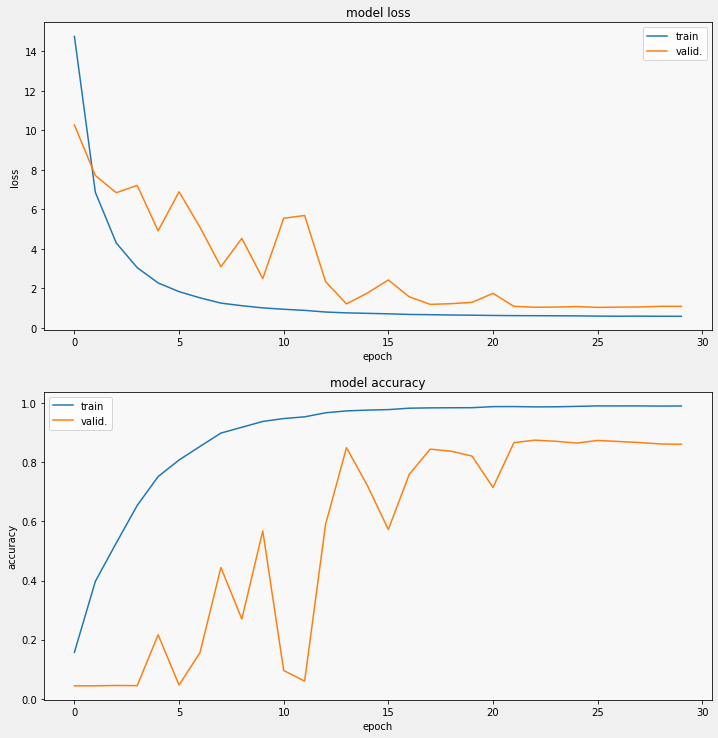

The EfficientNetB7 model with noisy-student weights have 

# Step 7: Evaluate Predictions #

Before making your final predictions on the test set, it's a good idea to evaluate your model's predictions on the validation set. This can help you diagnose problems in training or suggest ways your model could be improved. We'll look at two common ways of validation: plotting the **confusion matrix** and **visual validation**.

In [ ]:

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    

## Confusion Matrix ##

A [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) shows the actual class of an image tabulated against its predicted class. It is one of the best tools you have for evaluating the performance of a classifier.

The following cell does some processing on the validation data and then creates the matrix with the `confusion_matrix` function included in [`scikit-learn`](https://scikit-learn.org/stable/index.html).

In [ ]:
cmdataset = get_validation_dataset(ordered=True)
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()
cm_probabilities = eff.predict(images_ds)
cm_predictions = np.argmax(cm_probabilities, axis=-1)

labels = range(len(CLASSES))
cmat = confusion_matrix(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
)
cmat = (cmat.T / cmat.sum(axis=1)).T # normalize

You might be familiar with metrics like [F1-score](https://en.wikipedia.org/wiki/F1_score) or [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall). This cell will compute these metrics and display them with a plot of the confusion matrix. (These metrics are defined in the Scikit-learn module `sklearn.metrics`; we've imported them in the helper script for you.)

In [ ]:
score = f1_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
precision = precision_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
recall = recall_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
display_confusion_matrix(cmat, score, precision, recall)

## Visual Validation ##

It can also be helpful to look at some examples from the validation set and see what class your model predicted. This can help reveal patterns in the kinds of images your model has trouble with.

This cell will set up the validation set to display 20 images at a time -- you can change this to display more or fewer, if you like.

In [ ]:
dataset = get_validation_dataset()
dataset = dataset.unbatch().batch(20)
batch = iter(dataset)

And here is a set of flowers with their predicted species. Run the cell again to see another set.

In [ ]:
images, labels = next(batch)
probabilities = eff.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)

# Step 8: Make Test Predictions #

Once you're satisfied with everything, you're ready to make predictions on the test set.

In [ ]:
test_ds = get_test_dataset(ordered=True)

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = eff.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

We'll generate a file `submission.csv`. This file is what you'll submit to get your score on the leaderboard.

In [ ]:
print('Generating submission.csv file...')

# Get image ids from test set and convert to unicode
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

# Write the submission file
np.savetxt(
    'submission.csv',
    np.rec.fromarrays([test_ids, predictions]),
    fmt=['%s', '%d'],
    delimiter=',',
    header='id,label',
    comments='',
)

# Look at the first few predictions
!head submission.csv